In [1]:
import pandas as pd
import numpy as np 
from PyBundled.utils import  run_experiment


my_package is being imported


In [2]:
import spacy

nlp = spacy.load("en_core_web_lg",)

In [3]:
# load data 
data  = pd.read_csv('../data/bundled_raw.csv')

In [4]:
data.head()

,text,is_bundled
0,Emerson Community Experience,0
1,How could Emerson engage you in building a str...,0
2,"Discuss racism, anti-Semitism all forms of dis...",1
3,Regular communication,0
4,give staff time for this work,0


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       368
           1       0.31      0.09      0.14        58

    accuracy                           0.85       426
   macro avg       0.59      0.53      0.53       426
weighted avg       0.79      0.85      0.81       426

------------------
false negative rate =  0.9137931034482759
------------------


<AxesSubplot:>

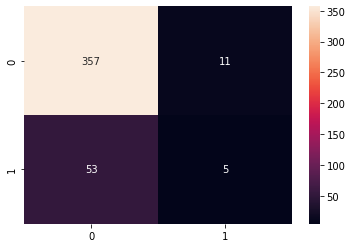

In [5]:
# count number of . in text
def count_dot(text):
    return text.count('.')
# count number of ? in text
def count_comma(text):
    return text.count(',')
# count number of non alphanumeric characters in text
def count_non_alphanumeric(text):
    numbers = sum(c.isdigit() for c in text)
    letters = sum(c.isalpha() for c in text)
    spaces  = sum(c.isspace() for c in text)
    others  = len(text) - numbers - letters - spaces
    return others
# count number of words in text
def count_words(text):
    return len(text.split())

def simple_feat_gen(data):
    data['dot_count'] = data['text'].apply(count_dot)
    data['comma_count'] = data['text'].apply(count_comma)
    data['non_alphanumeric_count'] = data['text'].apply(count_non_alphanumeric)
    data['word_count'] = data['text'].apply(count_words)
    return data[['dot_count','comma_count','non_alphanumeric_count','word_count','is_bundled']]

config = {
    'model_type': 'logistic',
    'feat_gen_func' : simple_feat_gen,
    'model_params': {} , 
    'cach_data': None

}
score, confusion_matrix, classification_report,fnr,features,cach_data = run_experiment(data,config=config)
print(classification_report)
print('------------------')
print('false negative rate = ',fnr)
print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       368
           1       0.94      0.83      0.88        58

    accuracy                           0.97       426
   macro avg       0.96      0.91      0.93       426
weighted avg       0.97      0.97      0.97       426

------------------
false negative rate =  0.1724137931034483
------------------


<AxesSubplot:>

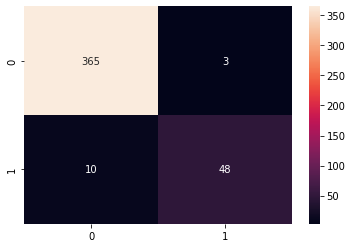

In [6]:
config = {
    'model_type': 'randomforest',
    'feat_gen_func' : simple_feat_gen,
    'model_params': {'n_estimators':20,} , 
    'cach_data': cach_data

}
score, confusion_matrix, classification_report,fnr,features,cach_data = run_experiment(data,config=config)
print(classification_report)
print('------------------')
print('false negative rate = ',fnr)
print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       368
           1       0.31      0.09      0.14        58

    accuracy                           0.85       426
   macro avg       0.59      0.53      0.53       426
weighted avg       0.79      0.85      0.81       426

------------------
false negative rate =  0.9137931034482759
------------------


<AxesSubplot:>

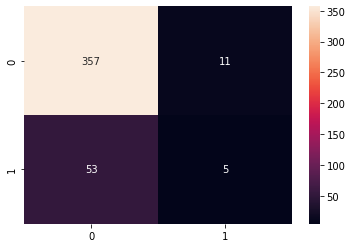

In [7]:
def split_into_sentences(text):
    doc = nlp(text)
    spans = []
    span =[]
    for token in doc : 
        if token.pos_=='PUNCT' and  token.text in [',','.','?','!',';'] :
            span_text = ' '.join(span)
            spans.append(span_text)
            span=[]
        else:
            span.append(token.text)
    span_text = ' '.join(span)
    spans.append(span_text)
    spans = [s for s in spans if s!='']
    return spans

def get_tockenize_len(text):
    sentences = split_into_sentences(text)
    return len(sentences)

def compute_similarity(pair):
    text1,text2 = pair
    doc1 = nlp(text1)
    doc2 = nlp(text2)
  
    return  doc1.similarity(doc2)

def get_sim_metric(text,agg='mean'):
    text_chunks = split_into_sentences(text)
    text_chunks_pairs = [text_chunks[i:i+2] for i in range(len(text_chunks)-1)]
    if len(text_chunks)<=1:
        return 1
    similarity_scores = [compute_similarity(pair) for pair in text_chunks_pairs]
    if agg=='mean':
        return np.mean(similarity_scores)
    elif agg=='min':
        return np.min(similarity_scores)
 

# apply to data 
def similarity_feat_gen(data):
    data['sentence_count'] = data['text'].apply(get_tockenize_len)
    data['similarity_mean'] = data['text'].apply(get_sim_metric,agg='mean')
    data['similarity_min'] = data['text'].apply(get_sim_metric,agg='min')
    return data[['sentence_count','similarity_mean','similarity_min','is_bundled']]
config = {
    'model_type': 'logistic',
    'model_params': {},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': None

}

score, confusion_matrix, classification_report,fnr,features,cach_data = run_experiment(data,config=config)
print(classification_report)
print('------------------')
print('false negative rate = ',fnr)
print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       368
           1       1.00      0.88      0.94        58

    accuracy                           0.98       426
   macro avg       0.99      0.94      0.96       426
weighted avg       0.98      0.98      0.98       426

------------------
false negative rate =  0.1206896551724138
------------------


<AxesSubplot:>

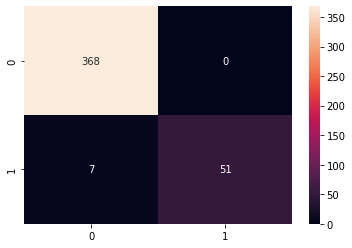

In [8]:
config = {
    'model_type': 'randomforest',
    'model_params': {'n_estimators':20,},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': cach_data

}
score, confusion_matrix, classification_report,fnr,features,cach_data = run_experiment(data,config=config)
print(classification_report)
print('------------------')
print('false negative rate = ',fnr)
print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

In [9]:
# Todo:
# inspect  false negative texts 